Домашнее задание:

К вам приходит руководитель продукта “Интернет-магазин” и спрашивает про удержание клиентов и повторные покупки.
У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали больше оттекать пользователи.
Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году? 

Задачи: 

- Проверить гипотезу руководителя продукта 
- Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
orders = pd.read_csv('orders.csv')
customers = pd.read_csv('customers.csv')

In [3]:
orders

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


In [4]:
customers

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord
...,...,...,...,...,...
788,CJ-11875,Carl Jackson,Corporate,Pennsylvania,Philadelphia
789,RS-19870,Roy Skaria,Home Office,Iowa,Burlington
790,SC-20845,Sung Chung,Consumer,Illinois,Arlington Heights
791,RE-19405,Ricardo Emerson,Consumer,Ohio,Kent


In [5]:
max(orders['order_date'])

'2017-12-30'

Последняя покупка была совершена в конце 2017 года, поэтому надо сравнить 2016 и 2017 год

Для начала посмотрим на Retention rate по когортам для людей, которые пришли в 2016-2017 году.

In [6]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['order_month'] = orders['order_date'].dt.strftime('%Y-%m')
orders['order_year'] = orders['order_date'].dt.strftime('%Y') 

In [7]:
cohorts= orders.groupby('customer_id', as_index=False)['order_month'].min()
cohorts.rename(columns = {'order_month':'cohort'}, inplace=True)
ord_coh = orders.merge(cohorts, how = 'left', on = 'customer_id')

In [8]:
ord_coh = ord_coh[ord_coh['cohort'] >= '2016-01-01']
ord_coh

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,cohort
1700,100083,2016-11-24,Standard,CD-11980,24.784,2016-11,2016,2016-11
1723,101525,2016-05-01,Second,CM-12235,140.520,2016-05,2016,2016-05
1730,101742,2016-09-23,Second,CR-12580,10.528,2016-09,2016,2016-04
1750,103128,2016-11-11,Standard,SC-20845,14.112,2016-11,2016,2016-11
1754,103709,2016-09-08,Standard,LP-17095,310.860,2016-09,2016,2016-06
...,...,...,...,...,...,...,...,...
4918,146416,2017-10-20,Second,JE-16165,24.678,2017-10,2017,2016-12
4924,147669,2017-12-25,Standard,SV-20935,484.323,2017-12,2017,2016-03
4955,155866,2017-11-17,Standard,CC-12370,226.640,2017-11,2017,2016-05
4970,160465,2017-07-21,Standard,SW-20350,466.814,2017-07,2017,2016-04


In [9]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['cohort_period'] = np.arange(len(df))
    return df

In [10]:
cohorts_group = ord_coh.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True) 
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.T

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
cohort,,,,,,,,,,,,,,,,,,
2016-02,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03,1.0,0.500000,0.500000,0.166667,0.166667,0.166667,0.166667,0.500000,0.166667,0.166667,0.333333,0.333333,0.166667,0.166667,0.166667,0.166667,0.666667,0.333333
2016-04,1.0,0.285714,0.142857,0.142857,0.571429,0.142857,0.285714,0.142857,0.142857,0.285714,0.285714,0.142857,0.142857,0.285714,NaN,NaN,NaN,NaN
2016-05,1.0,0.142857,0.285714,0.142857,0.142857,0.285714,0.142857,0.285714,0.142857,0.285714,0.142857,0.142857,0.285714,0.285714,0.142857,0.285714,0.285714,NaN
2016-06,1.0,0.125000,0.250000,0.375000,0.125000,0.125000,0.125000,0.125000,0.250000,0.250000,0.250000,0.375000,0.125000,0.375000,NaN,NaN,NaN,NaN
2016-07,1.0,0.500000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1.0,0.250000,0.250000,0.500000,0.500000,0.250000,0.250000,0.500000,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11,1.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.333333,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


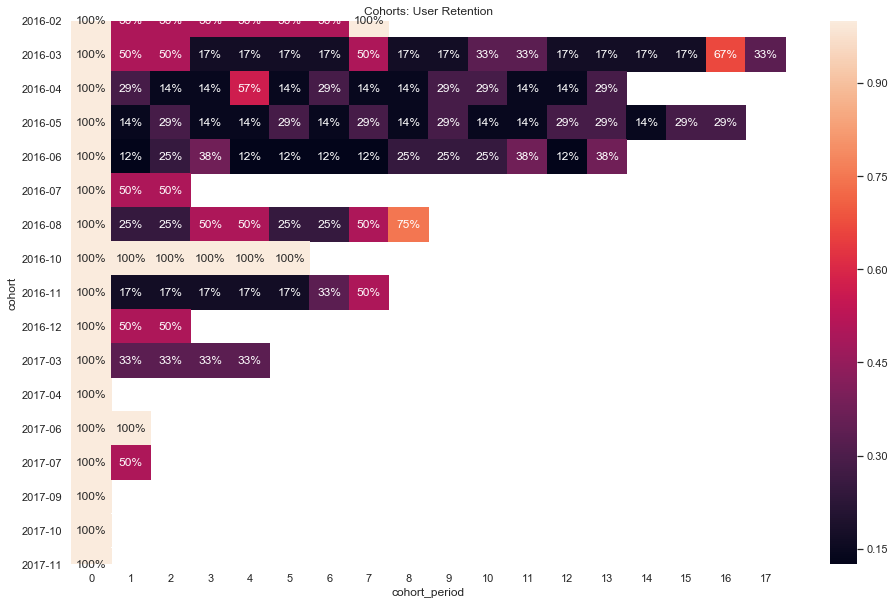

In [11]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Видно, что на диаграмме много пропущенных значений, потому что произошло деление на 0, то есть активных пользователей на начало периода не было, они ушли из магазина. Надо провести более подробный анализ, используя churn-rate - показатель оттока клиентов. 

$CR = \dfrac{C_1 + C_3 - C_2}{C_1} \times 100 \%$

$C_1$  - количество покупателей в начале периода

$C_2$ - количество покупателей в конце периода

$C_3$ - количество новых покупателей за период

В данной ситуации можно сравнить оттоки клиентов за год и месяца, а также по разным категориям доставки, сегмента покупателя и крупных штатов (город будет не показательным из-за их широкого разнообразия и отсутствия большого количества заказов из одного города).

In [12]:
def churn_rate(data, prev, begin, end, period_type = 'month'):
    c1_val = pd.unique(data[data[f'order_{period_type}'] == prev]['customer_id'])
    c2_val = pd.unique(data[(data[f'order_{period_type}'] >= begin) & (data[f'order_{period_type}'] < end)]['customer_id'])
    c3_val = set(c2_val) - set(c1_val)
    if len(c1_val) == 0:
        cr = 0
    else:
        cr = (len(c1_val) + len(c3_val) - len(c2_val)) / len(c1_val) * 100

    return cr

In [13]:
print('Отток за 2016 год:', churn_rate(orders, '2015', '2016', '2017', period_type = 'year'), '%')

Отток за 2016 год: 21.11692844677138 %


In [14]:
print('Отток за 2017 год:', churn_rate(orders, '2016', '2017', '2018', period_type = 'year'), '%')

Отток за 2017 год: 12.539184952978054 %


Получается, отток клиентов в 2017 году уменьшился по сравнению с 2016 годом. Посмотрим теперь на отток клиентов по месяцам за каждый год

In [15]:
m2016 = pd.date_range('2016-01', '2017-01', freq='M').strftime('%Y-%m')
prev2016 = pd.date_range('2015-12', '2016-12', freq='M').strftime('%Y-%m')
next2016 = pd.date_range('2016-02', '2017-02', freq='M').strftime('%Y-%m')
m2017 = pd.date_range('2017-01', '2018-01', freq='M').strftime('%Y-%m')
prev2017 = pd.date_range('2016-12', '2017-12', freq='M').strftime('%Y-%m')
next2017 = pd.date_range('2017-02', '2018-02', freq='M').strftime('%Y-%m')

cr2016 = []
cr2017 = []

for i in range(len(m2016)):
    cr2016.append(churn_rate(orders, prev2016[i], m2016[i], next2016[i]))
    cr2017.append(churn_rate(orders, prev2017[i], m2017[i], next2017[i]))
    

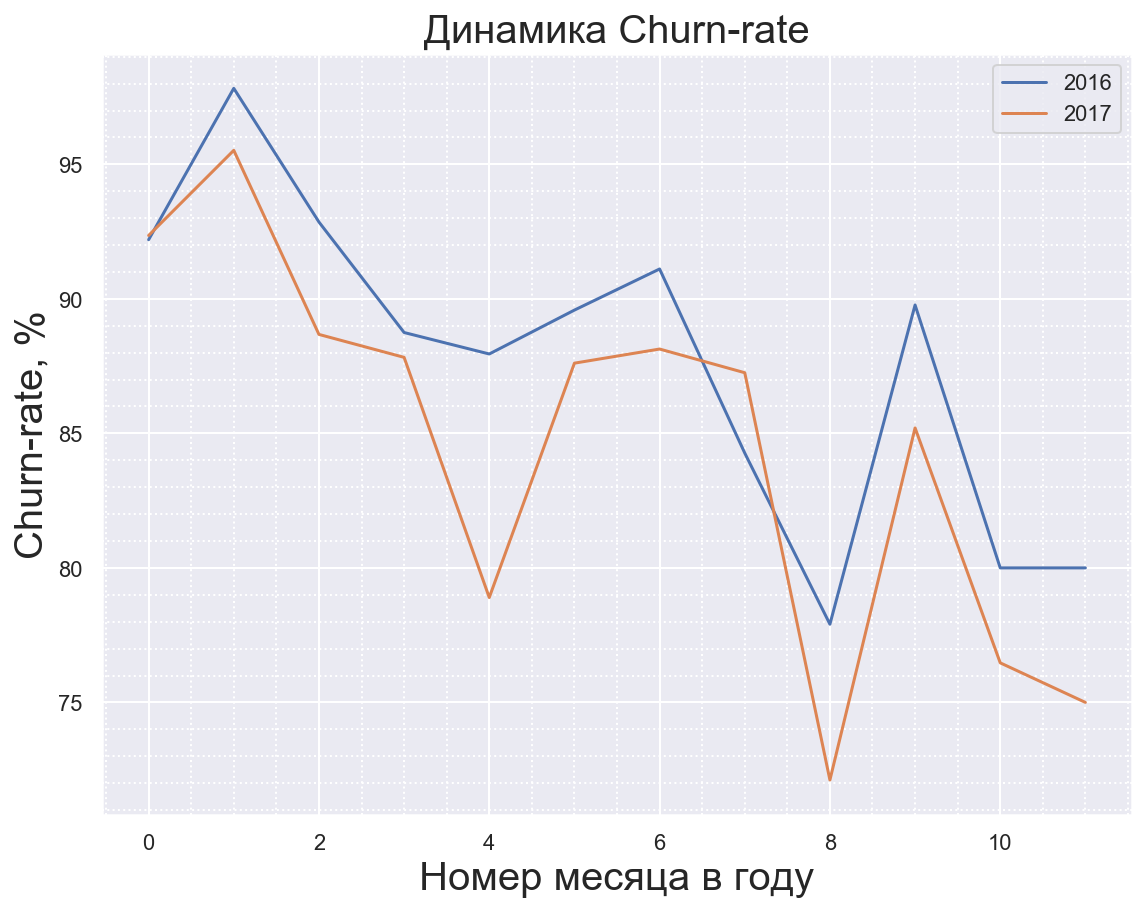

In [16]:
plt.rcParams['figure.figsize'] = 8, 6
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 13
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.title('Динамика Churn-rate', fontsize=20)
plt.xlabel('Номер месяца в году', fontsize=20)
plt.ylabel('Churn-rate, %', fontsize=20)
plt.plot(cr2016, label = '2016')
plt.plot(cr2017, label = '2017')
plt.legend()
plt.show()

В целом видно, что в 2017 отток меньше в одни и те же месяцы, паттерны похожие. В начале года отток большой, к концу уменьшается. В августе отток больше по сравнению с 2016 годом. Посмотрим для разных типов доставки.

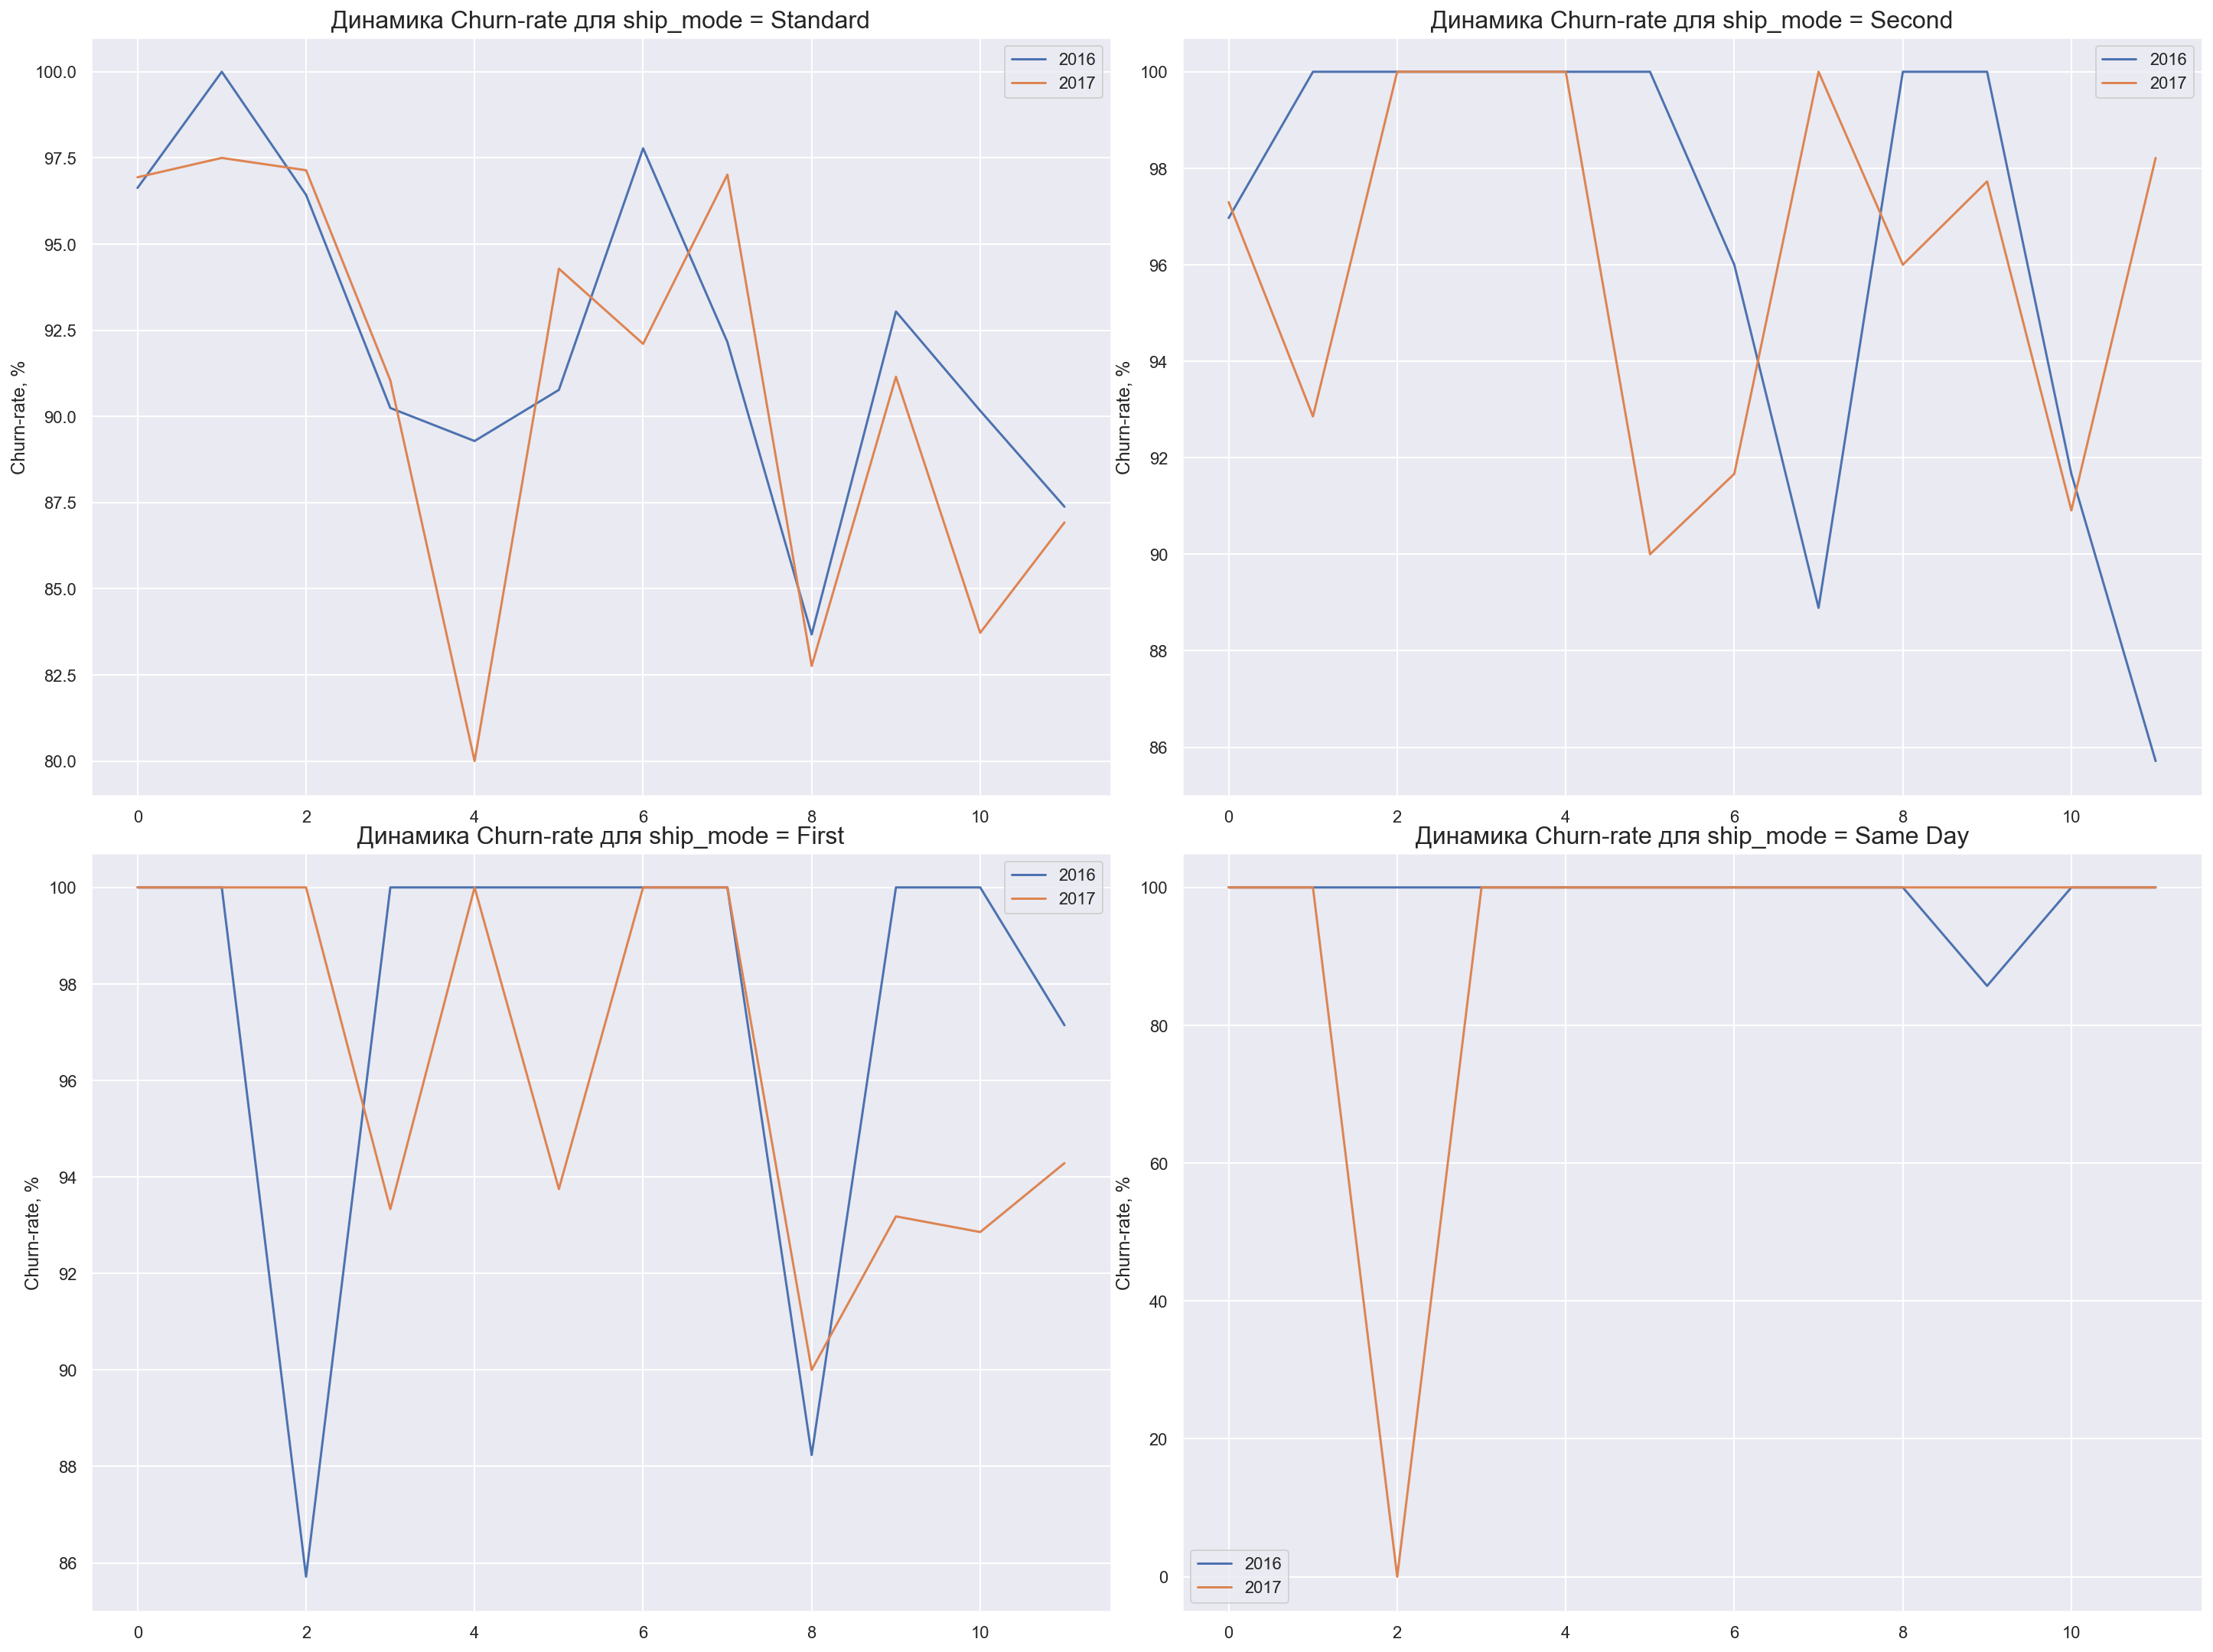

In [20]:
fig, axes = plt.subplots(2, 2)
plt.rcParams['figure.figsize'] = 20, 15
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

coord = [(0, 0), (0, 1), (1, 0), (1, 1)]

for j, mode in enumerate(['Standard', 'Second', 'First', 'Same Day']):
    cr2016_mode = []
    cr2017_mode = []

    for i in range(len(m2016)):
        cr2016_mode.append(churn_rate(orders[orders['ship_mode'] == mode], prev2016[i], m2016[i], next2016[i]))
        cr2017_mode.append(churn_rate(orders[orders['ship_mode'] == mode], prev2017[i], m2017[i], next2017[i]))
        
    
    axes[coord[j][0]][coord[j][1]].set_title(f'Динамика Churn-rate для ship_mode = {mode}', fontsize = 16) 
    axes[coord[j][0]][coord[j][1]].set_ylabel('Churn-rate, %')
    axes[coord[j][0]][coord[j][1]].plot(cr2016_mode, label = '2016')
    axes[coord[j][0]][coord[j][1]].plot(cr2017_mode, label = '2017')
    axes[coord[j][0]][coord[j][1]].legend()


Видно, что в августе 2017 отток увеличился и был намного больше чем в 2016 году для доставки Second и Standard. Для Second еще и в декабре. Для других типов доставки в основном в 2017 отток по месяцам меньше чем в 2016 году или такой же. Теперь посмотрим на разные сегменты покупателей.

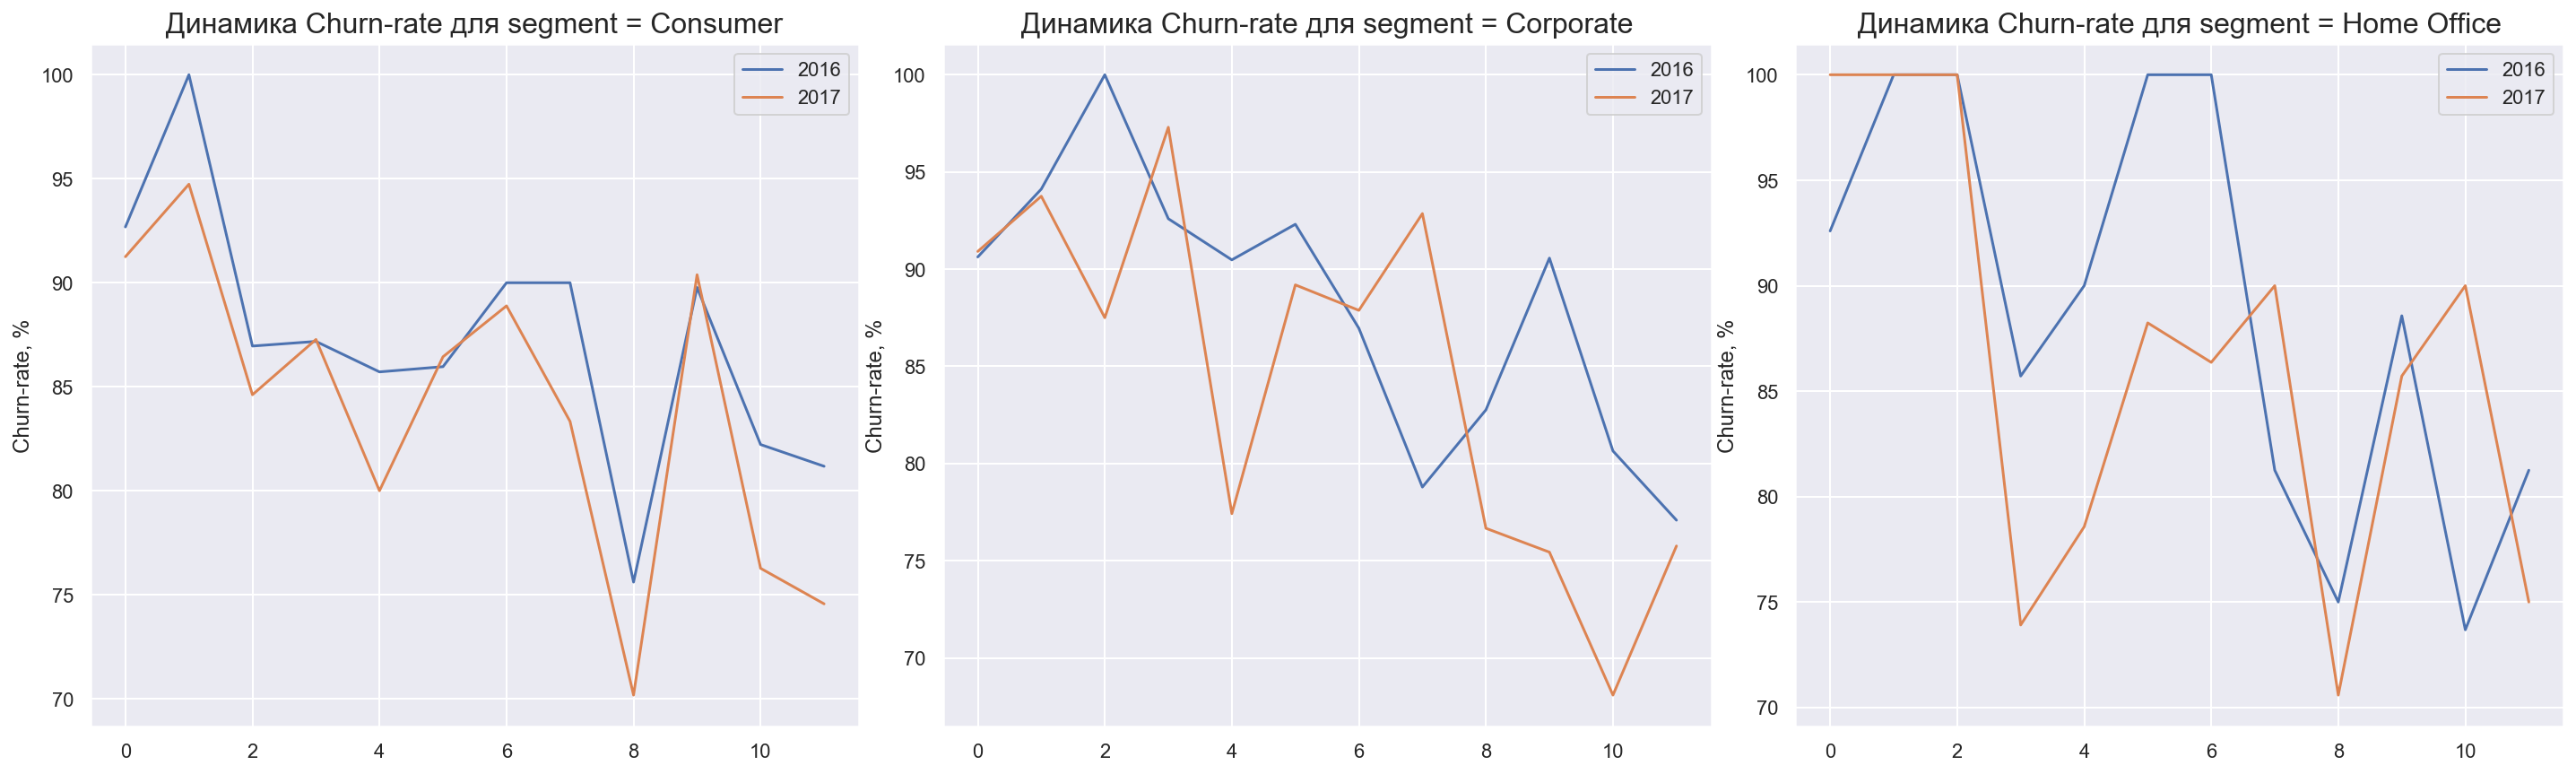

In [22]:
fig, axes = plt.subplots(1, 3)
plt.rcParams['figure.figsize'] = 20, 10
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

ord_cust = orders.merge(customers, how = 'left', left_on= 'customer_id', right_on = 'id')

for j, seg in enumerate(['Consumer', 'Corporate', 'Home Office']):
    cr2016_cust = []
    cr2017_cust = []

    for i in range(len(m2016)):
        cr2016_cust.append(churn_rate(ord_cust[ord_cust['segment'] == seg], prev2016[i], m2016[i], next2016[i]))
        cr2017_cust.append(churn_rate(ord_cust[ord_cust['segment'] == seg], prev2017[i], m2017[i], next2017[i]))
        
    
    axes[j].set_title(f'Динамика Churn-rate для segment = {seg}', fontsize = 16) 
    axes[j].set_ylabel('Churn-rate, %')
    axes[j].plot(cr2016_cust, label = '2016')
    axes[j].plot(cr2017_cust, label = '2017')
    axes[j].legend()


Для обычных покупателей в 2017 отток меньше чем в 2016, а вот для корпораций и офисов в августе опять увеличился отток по сравению с 2016. Для копораций еще и в апреле, для офисов в ноябре заметно увеличение оттока. Посмотрим на ситуацию в некоторых штатах, где заказов было больше всегов в 2016 и 2017 году.

In [23]:
cnt = ord_cust[(ord_cust['order_year'] == '2016') | (ord_cust['order_year'] == '2017')].groupby(by = ['order_year', 'state']).count()
pd.DataFrame(cnt.sort_values('customer_id', ascending = False)['customer_id']).rename(columns = {'customer_id':'cnt'}).head(10)

cnt
order_year state            
2017       California    326
2016       California    271
2017       New York      183
           Texas         163
2016       New York      141
           Texas         130
2017       Illinois      109
           Pennsylvania   94
2016       Illinois       92
2017       Washington     83

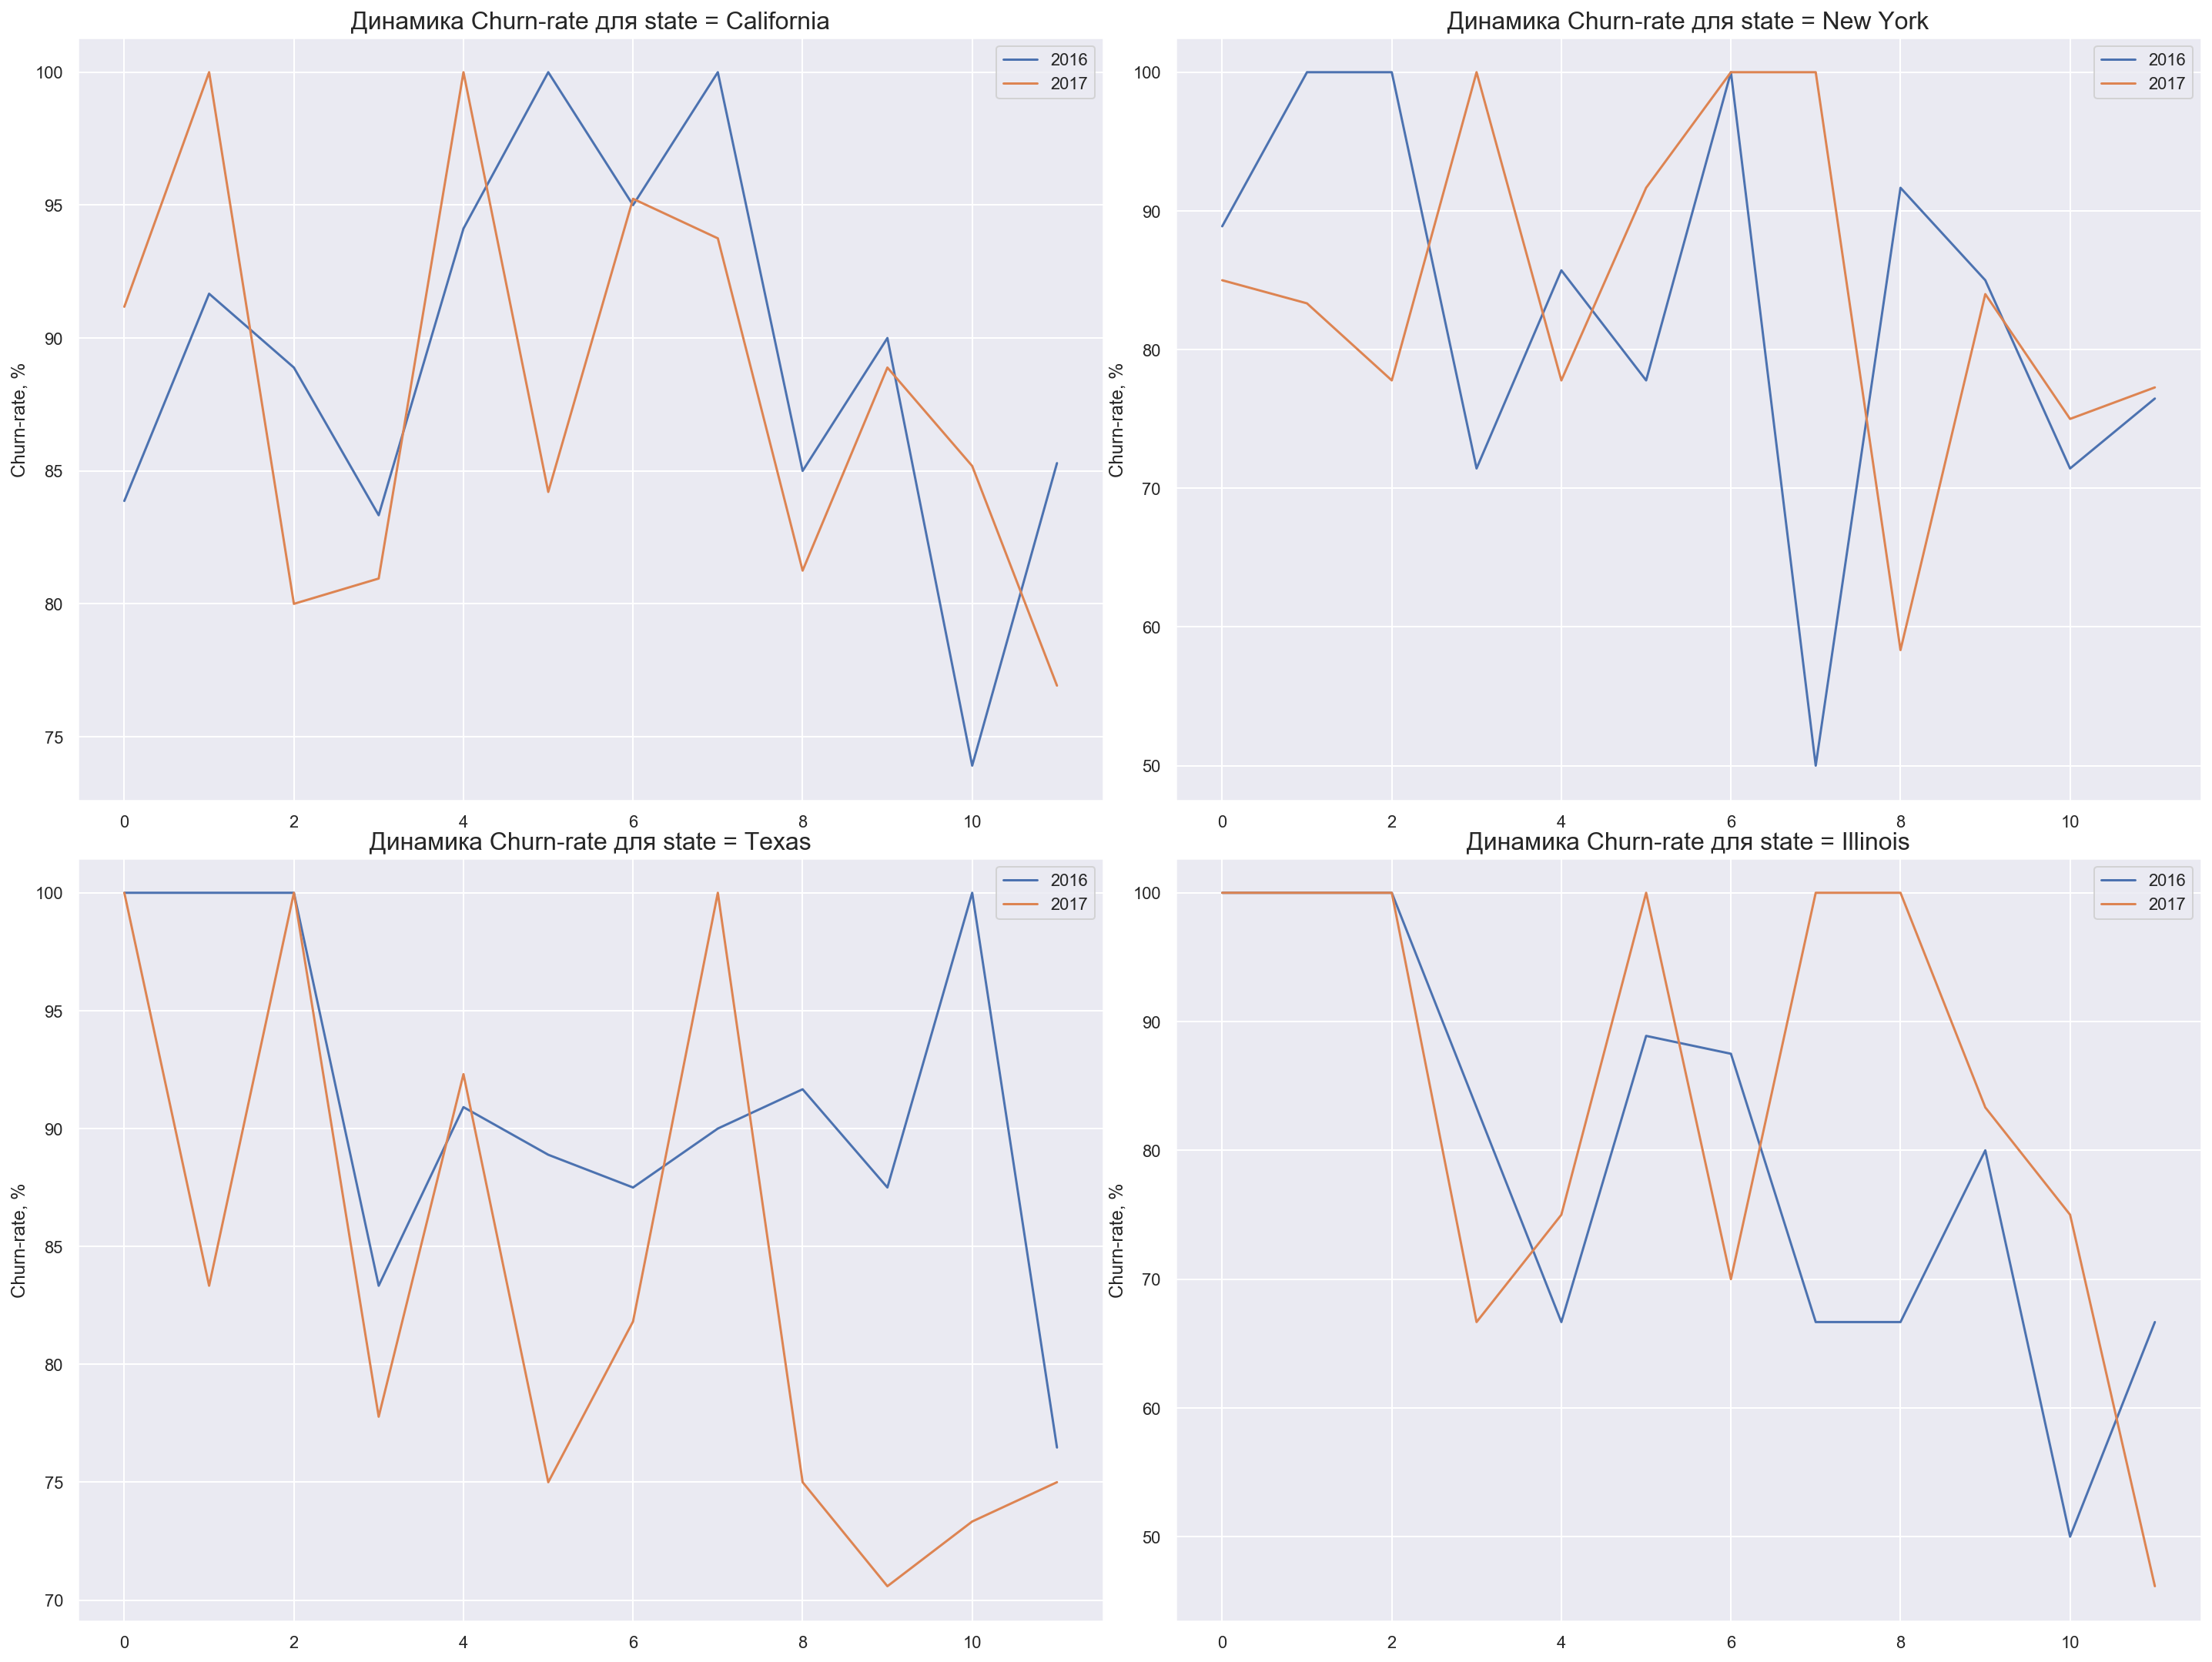

In [25]:
fig, axes = plt.subplots(2, 2)
plt.rcParams['figure.figsize'] = 20, 15
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

coord = [(0, 0), (0, 1), (1, 0), (1, 1)]

for j, state in enumerate(['California', 'New York', 'Texas', 'Illinois']):
    cr2016_cust = []
    cr2017_cust = []

    for i in range(len(m2016)):
        cr2016_cust.append(churn_rate(ord_cust[ord_cust['state'] == state], prev2016[i], m2016[i], next2016[i]))
        cr2017_cust.append(churn_rate(ord_cust[ord_cust['state'] == state], prev2017[i], m2017[i], next2017[i]))
        
    
    axes[coord[j][0]][coord[j][1]].set_title(f'Динамика Churn-rate для state = {state}', fontsize = 16) 
    axes[coord[j][0]][coord[j][1]].set_ylabel('Churn-rate, %')
    axes[coord[j][0]][coord[j][1]].plot(cr2016_cust, label = '2016')
    axes[coord[j][0]][coord[j][1]].plot(cr2017_cust, label = '2017')
    axes[coord[j][0]][coord[j][1]].legend()



В Калифорнии отток больше в феврале и в мае. В Нью-Йорке в апреле, июне и августе. В Техасе в августе. В Иллинойсе в мае, июне и августе - ноябре.

В целом видно, что почти во всех сегментах в августе отток увеличился по сравнению с 2016 годом, значит, надо найти проблему именно в этом месяце.